## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import TargetMaximizer
from karpiu.planning.calculator import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [3]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [29]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [39]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.04766,0.02871,0.06594,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.10855,0.09161,0.12565,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20670,0.18184,0.23232,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.09562,0.07110,0.12149,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.18943,0.16365,0.21638,1.00000,0.00000,0.00000,0.10000


In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

NameError: name 'mmm' is not defined

In [31]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11647.677306478374
            Iterations: 170
            Function evaluations: 26389
            Gradient evaluations: 166


In [32]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [33]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 490508
Total Budget: 490508


### Budget Allocation

In [34]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [35]:
df = mmm.get_raw_df()

In [36]:
df

,date,sales,promo,radio,search,social,tv
0,2019-01-01,888.00000,2003.00000,4779.00000,4603.00000,2123.00000,14120.00000
1,2019-01-02,978.00000,2210.00000,2676.00000,4028.00000,0.00000,7076.00000
2,2019-01-03,902.00000,0.00000,7219.00000,4037.00000,4000.00000,4118.00000
3,2019-01-04,904.00000,0.00000,7826.00000,3722.00000,0.00000,2926.00000
4,2019-01-05,972.00000,1076.00000,7877.00000,4353.00000,1771.00000,10259.00000
...,...,...,...,...,...,...,...
1062,2021-11-28,3037.00000,2143.00000,4028.00000,4762.00000,3858.00000,0.00000
1063,2021-11-29,3106.00000,2599.00000,0.00000,3328.00000,2232.00000,862.00000
1064,2021-11-30,3412.00000,2473.00000,0.00000,3901.00000,2765.00000,14481.00000
1065,2021-12-01,3198.00000,1068.00000,1583.00000,3879.00000,2198.00000,0.00000


In [85]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,72.16317,54.56168,76.79699,55.28816,55.32300,0.00000
radio,54.97775,34.85148,57.34654,38.16549,123.91600,50.65682
search,23.99325,33.13144,25.49489,37.91734,94.99100,225.34506
social,22.13891,33.65296,23.51090,37.93296,70.18200,251.82098
tv,75.16130,37.46793,80.47902,39.32227,185.88400,2.47315


### Outcome Plot

In [61]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

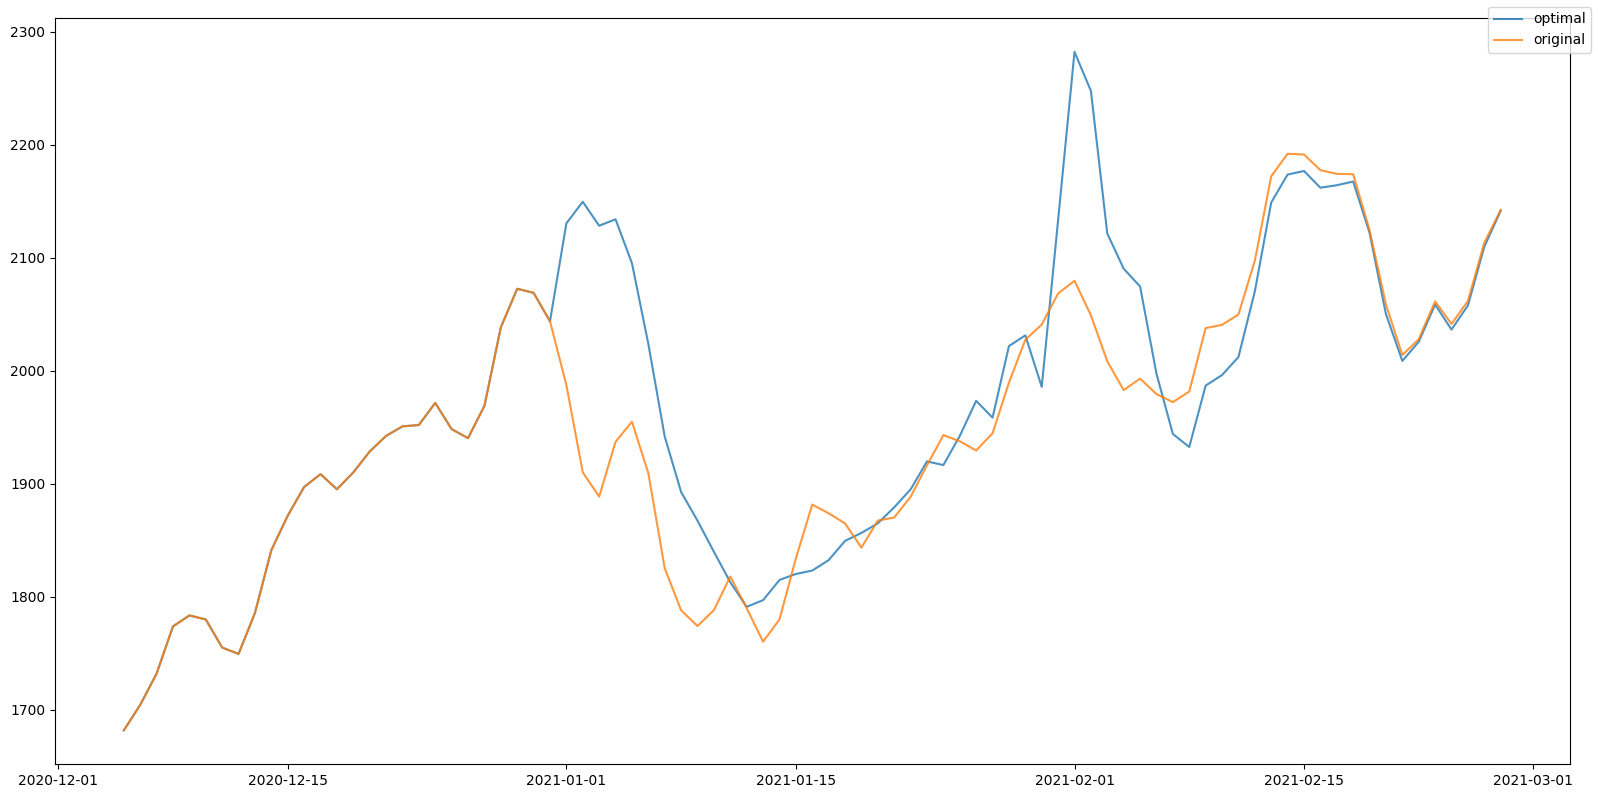

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
measurement_mask = (df["date"] >= maximizer.calc_start) & (
    df["date"] <= maximizer.calc_end
)
ax.plot(
    optim_pred.loc[measurement_mask, "date"].values,
    optim_pred.loc[measurement_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[measurement_mask, "date"].values,
    init_pred.loc[measurement_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [14]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[measurement_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[measurement_mask, "prediction"].values)
assert total_optim_pred > total_init_pred

In [6]:
import pytest
import numpy as np
import pandas as pd

from karpiu.models import MMM
from karpiu.simulation import make_mmm_daily_data
from karpiu.planning import TargetMaximizer, generate_cost_report

In [7]:
# data_args
seed = 2022
n_steps = 365 * 3
channels_coef = [0.053, 0.15, 0.19, 0.175, 0.15]
channels = ["promo", "radio", "search", "social", "tv"]
features_loc = np.array([2000, 5000, 3850, 3000, 7500])
features_scale = np.array([550, 2500, 500, 1000, 3500])
scalability = np.array([3.0, 1.25, 0.8, 1.3, 1.5])
start_date = "2019-01-01"
adstock_args = {
    "n_steps": 28,
    "peak_step": np.array([10, 8, 5, 3, 2]),
    "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
    "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
}
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.01,
}
np.random.seed(seed)

df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=adstock_args,
    with_yearly_seasonality=True,
    with_weekly_seasonality=True,
    country="US",
)

mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=channels,
    event_cols=event_cols,
    seed=seed,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
)
mmm.derive_saturation(df=df, scalability_df=scalability_df)
mmm.set_hyper_params(params=best_params)
mmm.fit(df, num_warmup=1000, num_sample=1000, chains=4)
budget_start = "2020-01-01"
budget_end = "2020-01-31"
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()
# always spend all budget in target maximization; assure the total preserves
assert np.allclose(np.sum(optim_spend_matrix), np.sum(init_spend_matrix))

cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)

pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values

2023-02-27 15:25:05 - karpiu-mmm - INFO - Initialize model
2023-02-27 15:25:05 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-27 15:25:05 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-27 15:25:05 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-27 15:25:05 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-27 15:25:05 - karpiu-mmm - INFO - Best params level_sm_input set as 0.01000
2023-02-27 15:25:05 - karpiu-mmm - INFO - Fit final model.
2023-02-27 15:25:05 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-27 15:25:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-02-27 15:25:57 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.6444090000000001) is within common range (0, 0.8].


Optimization terminated successfully    (Exit mode 0)
            Current function value: -7391.252814647293
            Iterations: 59
            Function evaluations: 9068
            Gradient evaluations: 58


/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:474: RuntimeWarning: overflow encountered in exp
  baseline_pred_comp =  np.exp(reg_comp + base_comp)
/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:497: RuntimeWarning: overflow encountered in exp
  new_pred_comp =  np.exp(new_reg_comp + base_comp)
/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:498: RuntimeWarning: invalid value encountered in subtract
  marginal_cost[idx] = np.sum(delta_matrix) / np.sum(new_pred_comp - baseline_pred_comp)
/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:474: RuntimeWarning: overflow encountered in exp
  baseline_pred_comp =  np.exp(reg_comp + base_comp)
/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:497: RuntimeWarning: overflow encountered in exp
  new_pred_comp =  np.exp(new_reg_comp + base_comp)
/Users/towinazure/edwinnglabs/karpiu/karpiu/planning/calculator.py:498: RuntimeWarning: invalid value encounter

In [16]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
    delta=1e-3,
)

pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values

In [17]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,72.16317,54.56168,469147.15739,360598.24124,55.32300,0.00000
radio,54.97775,34.85148,260810.81783,182432.16835,123.91600,50.65682
search,23.99325,33.13144,104671.65934,162988.80400,94.99100,225.34506
social,22.13891,33.65296,88686.97617,149651.66410,70.18200,251.82098
tv,75.16130,37.46793,626499.47314,320772.02676,185.88400,2.47315


In [109]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)

In [110]:
mmm.seasonality

[7, 365.25]

In [111]:
maximizer.base_comp.shape

(58,)

In [153]:
maximizer.calc_dt_array.shape

(85,)

In [112]:
coef_matrix = mmm.get_coef_matrix(date_array=maximizer.calc_dt_array[maximizer.n_max_adstock:], regressors=optim_channels)

In [113]:
coef_matrix.shape

(58, 5)

In [114]:
optim_channels

['promo', 'radio', 'search', 'social', 'tv']

In [146]:
regressors_matrix = df.loc[:, optim_channels].values
regressors_matrix.shape

(1095, 5)

In [144]:
maximizer.optim_coef_matrix.shape

(58, 5)

In [117]:
adstock_matrix =maximizer.optim_adstock_matrix

In [33]:
from karpiu.utils import adstock_process

In [157]:
input_spend_matrix = regressors_matrix[maximizer.calc_mask]
input_spend_matrix[:maximizer.n_max_adstock] = 0.
input_spend_matrix[-maximizer.n_max_adstock:] = 0.
input_spend_matrix += maximizer.bkg_spend_matrix

In [158]:
maximizer.bkg_spend_matrix.shape

(85, 5)

In [159]:
transformed_regressors_matrix = adstock_process(input_spend_matrix, adstock_matrix)
# pad zeros
# transformed_regressors_matrix = np.concatenate(
#     [
#         np.zeros((maximizer.n_max_adstock, len(optim_channels))),
#         transformed_regressors_matrix,
#     ], axis=0
# )
# transformed_regressors_matrix = transformed_regressors_matrix[maximizer.calc_mask]
# transformed_regressors_matrix = transformed_regressors_matrix[maximizer.n_max_adstock:]
transformed_regressors_matrix = np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)
transformed_regressors_matrix.shape

(58, 5)

In [160]:
reg_comp = np.sum(coef_matrix * transformed_regressors_matrix, axis=-1)
reg_comp

array([0.39967546, 0.44539999, 0.46916297, 0.45745876, 0.44083817,
       0.42607168, 0.43973575, 0.45187903, 0.46339098, 0.47111868,
       0.47552148, 0.48107203, 0.4929883 , 0.48839605, 0.4855006 ,
       0.46924156, 0.46370755, 0.46170411, 0.4434299 , 0.4587943 ,
       0.46784095, 0.46462112, 0.47342547, 0.47698099, 0.49072939,
       0.49310633, 0.50342412, 0.50480454, 0.51119437, 0.50660532,
       0.49028235, 0.49199175, 0.46946566, 0.45020852, 0.4364989 ,
       0.41804606, 0.4026799 , 0.41756263, 0.44177046, 0.46065184,
       0.45402659, 0.44925099, 0.47034692, 0.47153391, 0.45367155,
       0.41559209, 0.39068458, 0.39944189, 0.38388749, 0.38593701,
       0.39366776, 0.38635584, 0.39100045, 0.40507315, 0.40603093,
       0.38656996, 0.38074511, 0.39696346])

In [161]:
pred_comp_from_optim = np.exp(reg_comp + maximizer.base_comp)
pred_comp_from_optim

array([ 760.05420277, 1129.80326751, 1179.13508477, 1196.23657218,
       1216.89854935, 1136.28451183, 1047.40026244, 1063.3330824 ,
       1138.1213212 , 1166.69707834, 1205.43901802, 1258.68511927,
       1206.4826476 , 1091.90585255, 1089.01317601, 1131.04281886,
       1145.08066052, 1174.7073859 , 1196.24210068,  985.08716069,
       1055.05604551, 1053.60426991, 1122.30376229, 1148.92398123,
       1200.82181639, 1250.63601841, 1198.81831253, 1095.59411272,
       1107.93606395, 1170.72009033, 1181.10327716, 1224.62777475,
       1249.22495354, 1167.07835798, 1055.77848535, 1046.63151675,
       1100.00878438, 1147.01389069, 1220.44017239, 1304.29659262,
       1236.74704797, 1133.81403573, 1175.29897532, 1260.63443239,
       1280.73135745, 1286.7183882 , 1317.19382526, 1746.58189828,
       1160.2665593 , 1181.704191  , 1275.0854637 , 1304.5136084 ,
       1366.66039005, 1455.13439369, 1398.37576015, 1266.36269892,
       1280.01747306, 1392.65640102])

In [128]:
pred_df = mmm.predict(df)

In [129]:
pred_comp = pred_df.loc[maximizer.calc_mask, "prediction"].values
pred_comp = pred_comp[maximizer.n_max_adstock: ]

In [130]:
pred_comp

array([ 760.05420277, 1129.80326751, 1179.13508477, 1196.23657218,
       1216.89854935, 1136.28451183, 1047.40026244, 1063.3330824 ,
       1138.1213212 , 1166.69707834, 1205.43901802, 1258.68511927,
       1206.4826476 , 1091.90585255, 1089.01317601, 1131.04281886,
       1145.08066052, 1174.7073859 , 1196.24210068,  985.08716069,
       1055.05604551, 1053.60426991, 1122.30376229, 1148.92398123,
       1200.82181639, 1250.63601841, 1198.81831253, 1095.59411272,
       1107.93606395, 1170.72009033, 1181.10327716, 1224.62777475,
       1249.22495354, 1167.07835798, 1055.77848535, 1046.63151675,
       1100.00878438, 1147.01389069, 1220.44017239, 1304.29659262,
       1236.74704797, 1133.81403573, 1175.29897532, 1260.63443239,
       1280.73135745, 1286.7183882 , 1317.19382526, 1746.58189828,
       1160.2665593 , 1181.704191  , 1275.0854637 , 1304.5136084 ,
       1366.66039005, 1455.13439369, 1398.37576015, 1266.36269892,
       1280.01747306, 1392.65640102])

In [133]:
assert np.allclose(pred_comp_from_optim, pred_comp)

In [49]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()
# always spend all budget in target maximization; assure the total preserves
assert np.allclose(np.sum(optim_spend_matrix), np.sum(init_spend_matrix))

cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)

pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values

Optimization terminated successfully    (Exit mode 0)
            Current function value: -7391.252814647293
            Iterations: 59
            Function evaluations: 9068
            Gradient evaluations: 58
[0.00014417 0.00015811 0.0001647  0.00015878 0.00015228 0.00014699
 0.00015176 0.00015507 0.0001585  0.00016228 0.00016488 0.00016841
 0.00017296 0.00017015 0.00016921 0.00016514 0.0001639  0.00016399
 0.00015834 0.0001645  0.00016812 0.00016738 0.00016948 0.00016885
 0.00017407 0.0001755  0.00017799 0.00017692 0.00017827 0.00017699
 0.0001708  0.0001707  0.00016266 0.00015685 0.00015265 0.00014737
 0.00014367 0.00015016 0.00015776 0.00016339 0.00015973 0.00015678
 0.00016393 0.000165   0.00015845 0.00014452 0.00013521 0.00013859
 0.00013177 0.0001314  0.00013484 0.00013394 0.00013583 0.00014072
 0.00014186 0.00013624 0.00013292 0.00013694]
[0.00016865 0.00022239 0.00023499 0.00024109 0.00023684 0.00022453
 0.00020916 0.00020534 0.00020822 0.00021084 0.00021918 0.00022248
 0.00

In [47]:
np.exp(maximizer.base_comp)

array([ 509.64494331,  723.71582317,  737.57922346,  757.08607777,
        783.07036662,  742.07279347,  674.7421918 ,  676.73830111,
        716.04516318,  728.37304826,  749.25368942,  778.01893662,
        736.91768709,  670.00413736,  670.16678837,  707.44067312,
        720.19557767,  740.31091394,  767.78553087,  622.61965612,
        660.83766491,  662.05662044,  699.04373619,  713.08464434,
        735.11875531,  763.79634577,  724.63457481,  661.32640624,
        664.51655221,  705.4027943 ,  723.37076849,  748.74649918,
        781.18573451,  744.00685728,  682.34457814,  689.03092153,
        735.3845377 ,  755.48097543,  784.61755848,  822.84457264,
        785.41580974,  723.4934461 ,  734.30973211,  786.69174066,
        813.63756848,  849.16905223,  891.20482059, 1171.4224615 ,
        790.38294087,  803.33828123,  860.14478278,  886.4544049 ,
        924.3815549 ,  970.46990521,  931.7231718 ,  860.34553098,
        874.70256082,  936.36449808])

In [48]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)

pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values

[0.00014417 0.00015811 0.0001647  0.00015878 0.00015228 0.00014699
 0.00015176 0.00015507 0.0001585  0.00016228 0.00016488 0.00016841
 0.00017296 0.00017015 0.00016921 0.00016514 0.0001639  0.00016399
 0.00015834 0.0001645  0.00016812 0.00016738 0.00016948 0.00016885
 0.00017407 0.0001755  0.00017799 0.00017692 0.00017827 0.00017699
 0.0001708  0.0001707  0.00016266 0.00015685 0.00015265 0.00014737
 0.00014367 0.00015016 0.00015776 0.00016339 0.00015973 0.00015678
 0.00016393 0.000165   0.00015845 0.00014452 0.00013521 0.00013859
 0.00013177 0.0001314  0.00013484 0.00013394 0.00013583 0.00014072
 0.00014186 0.00013624 0.00013292 0.00013694]
[0.00016865 0.00022239 0.00023499 0.00024109 0.00023684 0.00022453
 0.00020916 0.00020534 0.00020822 0.00021084 0.00021918 0.00022248
 0.00021474 0.00020013 0.00018895 0.00019515 0.00019478 0.00020183
 0.0001989  0.00017953 0.00017438 0.00017029 0.00017729 0.0001827
 0.00020227 0.00020764 0.00019288 0.00017712 0.00016707 0.00015258
 0.00021843 0.000

In [43]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,72.16317,54.56168,469152.94490,360598.24124,55.32300,0.00000
radio,54.97775,34.85148,260812.60522,182432.16835,123.91600,50.65682
search,23.99325,33.13144,104672.58027,162988.80400,94.99100,225.34506
social,22.13891,33.65296,88687.92503,149651.66410,70.18200,251.82098
tv,75.16130,37.46793,626517.05625,320772.02676,185.88400,2.47315


In [34]:
df = maximizer.get_df()
date_col = "date"
spend_start = maximizer.budget_start
spend_end = maximizer.budget_end
max_adstock = maximizer.n_max_adstock

mea_start = spend_start
mea_end = spend_end + pd.Timedelta(days=max_adstock)
calc_start = spend_start - pd.Timedelta(days=max_adstock)
calc_end = spend_end + pd.Timedelta(days=max_adstock)

spend_mask = (df[date_col] >= spend_start) & (df[date_col] <= spend_end)
mea_mask = (df[date_col] >= mea_start) & (df[date_col] <= mea_end)
calc_mask = (df[date_col] >= calc_start) & (df[date_col] <= calc_end)

In [35]:
transformed_regressors_matrix = adstock_process(regressors_matrix, adstock_matrix)
# pad zeros
transformed_regressors_matrix = np.concatenate(
    [
        np.zeros((maximizer.n_max_adstock, len(optim_channels))),
        transformed_regressors_matrix,
    ], axis=0
)
transformed_regressors_matrix = transformed_regressors_matrix[maximizer.calc_mask]
transformed_regressors_matrix = transformed_regressors_matrix[maximizer.n_max_adstock:]
transformed_regressors_matrix = np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)

NameError: name 'regressors_matrix' is not defined

In [ ]:
pred_comp_from_optim = np.exp(reg_comp + maximizer.base_comp)

In [37]:
from copy import deepcopy

In [38]:
# define the baseline parameters

coef_matrix = maximizer.optim_coef_matrix
adstock_matrix =maximizer.optim_adstock_matrix
input_spend_matrix = df.loc[maximizer.calc_mask, channels].values
# input_spend_matrix = input_spend_matrix[maximizer.n_max_adstock:]
# input_spend_matrix = input_spend_matrix[:-maximizer.n_max_adstock]
input_spend_base_matrix = deepcopy(input_spend_matrix)

In [39]:
# adstock, log1p, saturation
transformed_regressors_matrix = adstock_process(input_spend_base_matrix, adstock_matrix)
transformed_regressors_matrix = np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)

reg_comp = np.sum(coef_matrix * transformed_regressors_matrix, axis=-1)
# from maximizer parameters
base_pred_comp = np.exp(reg_comp + maximizer.base_comp)

In [40]:
marginal_cost = np.empty(len(channels))
for idx, ch in enumerate(channels):
    delta = 1e-1

    delta_matrix = np.zeros_like(input_spend_matrix)
    delta_matrix[max_adstock:-max_adstock, idx] = delta
    new_spend_matrix = input_spend_base_matrix + delta_matrix

    # adstock, log1p, saturation
    transformed_regressors_matrix = adstock_process(new_spend_matrix, adstock_matrix)
    transformed_regressors_matrix = np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)

    reg_comp = np.sum(coef_matrix * transformed_regressors_matrix, axis=-1)
    # from maximizer parameters
    delta_pred_comp_from = np.exp(reg_comp + maximizer.base_comp)
    marginal_cost[idx] = np.sum(delta_matrix) / np.sum(delta_pred_comp_from - base_pred_comp)

In [41]:
marginal_cost

array([76.79698879, 57.34654461, 25.49489206, 23.51090423, 80.4790226 ])

In [179]:
channels

['promo', 'radio', 'search', 'social', 'tv']

In [180]:
mmm.get_saturation_vector(regressors=channels)

array([3854.4 , 2838.75, 2564.72, 2364.44, 4862.4 ])

In [44]:
base_pred_comp

array([ 760.05420277, 1129.80326751, 1179.13508477, 1196.23657218,
       1216.89854935, 1136.28451183, 1047.40026244, 1063.3330824 ,
       1138.1213212 , 1166.69707834, 1205.43901802, 1258.68511927,
       1206.4826476 , 1091.90585255, 1089.01317601, 1131.04281886,
       1145.08066052, 1174.7073859 , 1196.24210068,  985.08716069,
       1055.05604551, 1053.60426991, 1122.30376229, 1148.92398123,
       1200.82181639, 1250.63601841, 1198.81831253, 1095.59411272,
       1107.93606395, 1170.72009033, 1181.10327716, 1224.62777475,
       1249.22495354, 1167.07835798, 1055.77848535, 1046.63151675,
       1100.00878438, 1147.01389069, 1220.44017239, 1304.29659262,
       1236.74704797, 1133.81403573, 1175.29897532, 1260.63443239,
       1280.73135745, 1286.7183882 , 1317.19382526, 1746.58189828,
       1160.2665593 , 1181.704191  , 1275.0854637 , 1304.5136084 ,
       1366.66039005, 1455.13439369, 1398.37576015, 1266.36269892,
       1280.01747306, 1392.65640102])

In [66]:
# adstock, log1p, saturation
transformed_regressors_matrix = adstock_process(input_spend_base_matrix, adstock_matrix)
transformed_regressors_matrix = np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)

reg_comp = np.sum(coef_matrix * transformed_regressors_matrix, axis=-1)

In [78]:
np.log1p(transformed_regressors_matrix / maximizer.optim_sat_array)

array([[0.00008744, 0.00025358, 0.00026628, 0.00028744, 0.00009952],
       [0.00009208, 0.00029123, 0.00029903, 0.00028565, 0.00013245],
       [0.00009385, 0.00030753, 0.00030787, 0.00028756, 0.00015697],
       [0.00009511, 0.00032072, 0.00027509, 0.00027528, 0.00016702],
       [0.00009527, 0.00033627, 0.00023993, 0.00026933, 0.0001647 ],
       [0.0000958 , 0.00033927, 0.00022709, 0.00025576, 0.00015766],
       [0.00009242, 0.00036111, 0.00024219, 0.00025203, 0.00016141],
       [0.00009243, 0.00038296, 0.00024527, 0.00024745, 0.00017251],
       [0.00009194, 0.00038279, 0.00025295, 0.00025161, 0.0001838 ],
       [0.00009194, 0.00036028, 0.00028165, 0.00025758, 0.00017939],
       [0.00009209, 0.00033185, 0.000315  , 0.00025593, 0.00017345],
       [0.00009269, 0.00034325, 0.0003302 , 0.0002615 , 0.00015913],
       [0.00009256, 0.00035818, 0.00034263, 0.00026504, 0.00015898],
       [0.00009271, 0.00035344, 0.00032061, 0.00026912, 0.00017015],
       [0.00009402, 0.00034685, 0.

In [67]:
transformed_regressors_matrix

array([[0.33706134, 0.71993071, 0.68302954, 0.67972881, 0.48390589],
       [0.35493149, 0.82685507, 0.76704186, 0.6755015 , 0.64406286],
       [0.36174112, 0.87314294, 0.78973036, 0.68001471, 0.76329504],
       [0.36660122, 0.91059976, 0.70563167, 0.65098261, 0.81217192],
       [0.36722716, 0.95474852, 0.6154283 , 0.63690384, 0.8008976 ],
       [0.36927131, 0.96327456, 0.58249974, 0.60481692, 0.76664806],
       [0.35624749, 1.02527723, 0.62122815, 0.5959763 , 0.78492236],
       [0.35628541, 1.08734612, 0.62913709, 0.58515454, 0.83887252],
       [0.35437596, 1.08686695, 0.64882312, 0.59499688, 0.89379608],
       [0.35440508, 1.0229422 , 0.72244786, 0.60910047, 0.87234101],
       [0.3549719 , 0.94220553, 0.80800259, 0.60520818, 0.84345682],
       [0.35729309, 0.97457919, 0.84700563, 0.61838816, 0.7738366 ],
       [0.35678884, 1.01697554, 0.87888837, 0.62675043, 0.77310012],
       [0.3573559 , 1.00349282, 0.82240299, 0.63639582, 0.82741351],
       [0.36239049, 0.98477995, 0.

In [82]:
calculate_marginal_cost(
    mmm,
    channels=channels,
    spend_start=budget_start,
    spend_end=budget_end,
    spend_df=df,
)

,marginal_cost
regressor,
promo,76.79699
radio,57.34654
search,25.49489
social,23.51090
tv,80.47902


In [83]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)

pre_ac = cost_report["pre-opt-avg-cost"].values
pre_mc = cost_report["pre-opt-marginal-cost"].values
post_ac = cost_report["post-opt-avg-cost"].values
post_mc = cost_report["post-opt-marginal-cost"].values

In [70]:
maximizer.optim_sat_array

array([3854.4 , 2838.75, 2564.72, 2364.44, 4862.4 ])

In [71]:
mmm.get_saturation_vector(regressors=channels)

array([3854.4 , 2838.75, 2564.72, 2364.44, 4862.4 ])

In [84]:
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,72.16317,54.56168,76.79699,55.28816,55.32300,0.00000
radio,54.97775,34.85148,57.34654,38.16549,123.91600,50.65682
search,23.99325,33.13144,25.49489,37.91734,94.99100,225.34506
social,22.13891,33.65296,23.51090,37.93296,70.18200,251.82098
tv,75.16130,37.46793,80.47902,39.32227,185.88400,2.47315
